### Let's train fomo!!

This notebook covers the training of fomo with the HC dataset. Before training, make sure that the FOMO labels and images were generated. as explained in the dataset directory

In [3]:
import os
import sys
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization, Conv2D, DepthwiseConv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)
from DatasetLoader import DatasetLoader as dl
from save_info import save_model_info

2025-05-06 22:15:38.573294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746562538.591614 1120252 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746562538.597551 1120252 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746562538.613240 1120252 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746562538.613257 1120252 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746562538.613259 1120252 computation_placer.cc:177] computation placer alr

The original fomo model

In [4]:
def build_model(input_shape: tuple, weights: str, alpha: float,
                num_classes: int) -> tf.keras.Model:
    """ Construct a constrained object detection model.

    Args:
        input_shape: Passed to MobileNet construction.
        weights: Weights for initialization of MobileNet where None implies
            random initialization.
        alpha: MobileNet alpha value.
        num_classes: Number of classes, i.e. final dimension size, in output.

    Returns:
        Uncompiled keras model.

    Model takes (B, H, W, C) input and
    returns (B, H//8, W//8, num_classes) logits.
    """

    #! First create full mobile_net_V2 from (HW, HW, C) input
    #! to (HW/8, HW/8, C) output
    mobile_net_v2 = MobileNetV2(input_shape=input_shape,
                                weights=weights,
                                alpha=alpha,
                                include_top=True)
    #! Default batch norm is configured for huge networks, let's speed it up
    for layer in mobile_net_v2.layers:
        if type(layer) == BatchNormalization:
            layer.momentum = 0.9
    #! Cut MobileNet where it hits 1/8th input resolution; i.e. (HW/8, HW/8, C)
    cut_point = mobile_net_v2.get_layer('block_6_expand_relu')
    #! Now attach a small additional head on the MobileNet
    model = Conv2D(filters=32, kernel_size=1, strides=1,
                activation='relu', name='head')(cut_point.output)
    logits = Conv2D(filters=num_classes, kernel_size=1, strides=1,
                    activation=None, name='logits')(model)

    return Model(inputs=mobile_net_v2.input, outputs=logits)

Load the models in, rgb images so we can use mobilenet weights

In [5]:
models = []
sizes = [96, 128, 224]
a = [0.35, 0.75]
names = []

for j in a:
    for i in sizes:
        models.append(build_model((i, i, 3), "imagenet", j, 2))
        #save_model_info(name=f"fomo_a{str(j).replace('.', '')}_r{i}", model=models[-1], path="model_info.yaml")
        names.append(f"fomo_a{str(j).replace('.', '')}_r{i}")

I0000 00:00:1746562554.690351 1120252 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


#### 2. Create datasets

In [ ]:
datasets = []
train_ds = []

val_datasets = []
val_ds = []

counts = []
dl_loaders = []

for r in range(len(sizes)):
    dl_loaders.append(dl("RGB", "fomo-obj", sizes[r]))

    ds, c = dl_loaders[-1].get_dataset("train")
    datasets.append(ds.shuffle(c, reshuffle_each_iteration=True))
    counts.append(c)

    train_ds.append((datasets[-1]
        .shuffle(c)
        .map(lambda f, c: dl_loaders[-1].get_sample_fomo(f, c, train=True), 
                num_parallel_calls=tf.data.AUTOTUNE)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)))

    ds, c = dl_loaders[-1].get_dataset("test")
    val_datasets.append(ds)
    val_ds.append((val_datasets[-1]
        .map(lambda f, c: dl_loaders[-1].get_sample_fomo(f, c, train=False), 
                num_parallel_calls=tf.data.AUTOTUNE)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)))

Check if the random flip and brightness works

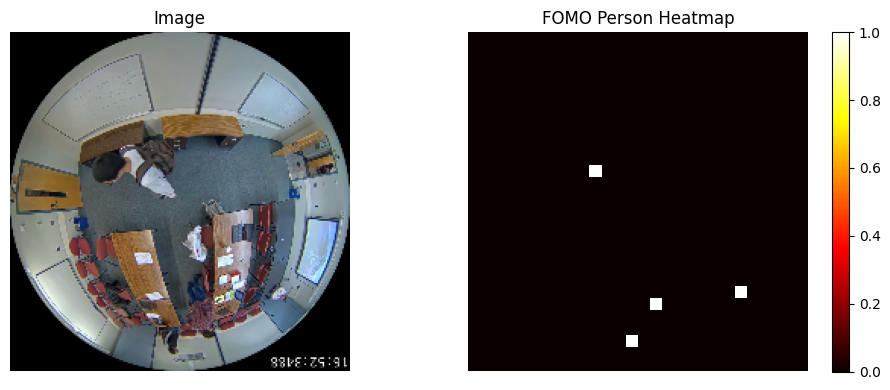

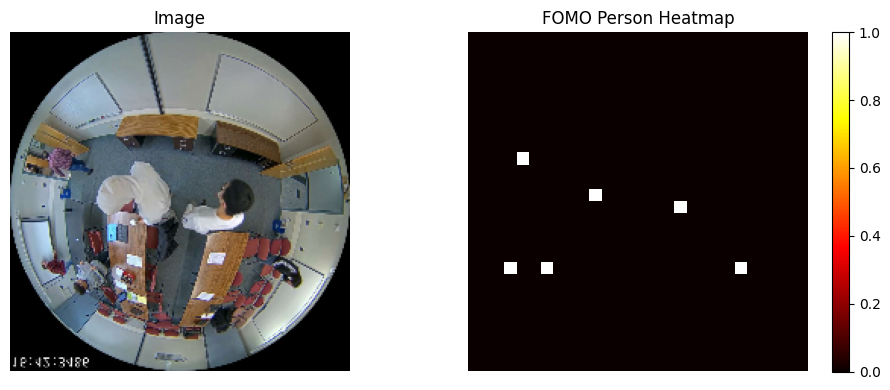

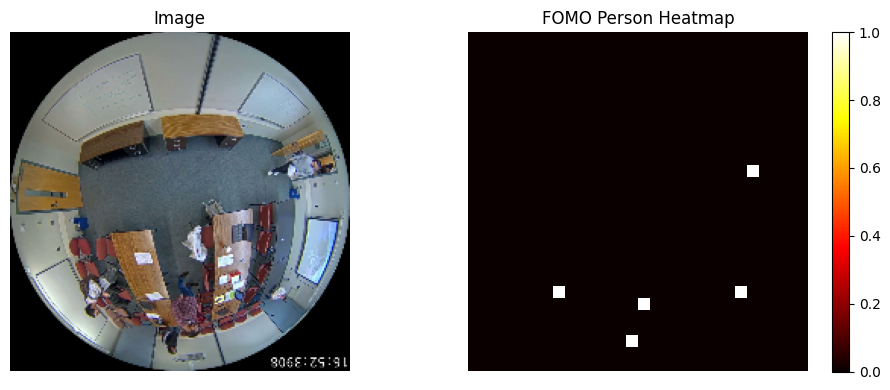

In [10]:
for images, anns in train_ds[-1].take(1):
    break

def show_fomo_sample(image, ann, idx=0):
    img = image[idx].numpy()
    ann_map = ann[idx].numpy()[..., 0]  # class 0 = person

    plt.figure(figsize=(10, 4))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    # Show heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(ann_map, cmap="hot", interpolation="nearest")
    plt.title("FOMO Person Heatmap")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show the first 3 examples
for i in range(3):
    show_fomo_sample(images, anns, idx=i)

Now before going further we need to compile the model. FOMO uses and adam optimizer and a weighted xent (cross entropy loss) with a weight of 100.

In [11]:
import model_loss
for i in range(len(models)):
    weighted_xent = model_loss.construct_weighted_xent_fn(models[i].output.shape, 100)
    models[i].compile(loss=weighted_xent,
                        optimizer="adam")

lets evaluate the models before training

In [12]:
model_to_ds = {"r96": [train_ds[0], val_ds[0]],
               "r128": [train_ds[1], val_ds[1]],
               "r224": [train_ds[2], val_ds[2]]}

loss = np.zeros(len(models))

for i in range(len(models)):
    for n, ds in model_to_ds.items():
        if n in names[i]:
            loss[i] = models[i].evaluate(ds[-1])
            break


I0000 00:00:1746562657.859143 1120380 service.cc:152] XLA service 0x7c062c001820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746562657.859168 1120380 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-05-06 22:17:37.948245: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746562658.300726 1120380 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 32.6076

I0000 00:00:1746562659.431526 1120380 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - loss: 32.2445
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - loss: 31.5488
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - loss: 82.4205
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - loss: 100.5696
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - loss: 7.6323
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - loss: 26.7424


Now lets train the model

In [13]:
NUM_EPOCHS = 30

lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1,
                                                 mode='auto', min_delta=0.0005, cooldown=0, min_lr=0)
checkpoint_filepath = []

count = 0

for c in range(5):
    count = 0
    for j in a:
        for i in sizes:
            checkpoint_filepath.append(f"out_m/fomo_a{str(j).replace('.', '')}_r{i}_{c}.keras")
            print(checkpoint_filepath[-1])
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath[-1],
                                                                    save_weights_only=False,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
            
            start_time = time.time()
            models[count].fit(train_ds[count%3],
                    epochs=NUM_EPOCHS,
                    validation_data=val_ds[count%3],
                    callbacks=[lr_scheduler_callback, model_checkpoint_callback])
            print(f"Total training time = {time.time() - start_time:.2f} seconds")
            
            count += 1

out_m/fomo_a035_r96_0.keras
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - loss: 15.2254 - val_loss: 1.1241 - learning_rate: 0.0010
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.7528 - val_loss: 0.3541 - learning_rate: 0.0010
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.3470 - val_loss: 0.2639 - learning_rate: 0.0010
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.2758 - val_loss: 0.2395 - learning_rate: 0.0010
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.2557 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.2477 - val_loss: 0.2190 - learning_rate: 0.0010
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.2349 - val_loss: 0.2081 - learning_rate: 0.0010
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.2272 - val_loss: 0.1987 - learning_rate: 0.0010
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.2205 - val_loss: 0.1935 - learning_

In [16]:
import yaml
import re
import model_loss as ml
RES_FILE = "results_m.yaml"

def write_res(file_path, name, new_metrics):

    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        with open(file_path, 'r') as file:
            existing_data = yaml.safe_load(file) or {}
    else:
        existing_data = {}

    existing_data[name] = new_metrics

    with open(file_path, 'w') as file:
        yaml.dump(existing_data, file, sort_keys=False)

for i in checkpoint_filepath:
    res = int(re.search(r"r(\d+)", i).group(1))
    loss_fn = ml.construct_weighted_xent_fn((1, res // 8, res // 8, 2), object_weight=100)
    saved_model = tf.keras.models.load_model(i, compile=True, custom_objects={"weighted_xent": loss_fn})

    loss = saved_model.evaluate(model_to_ds[f"r{str(res)}"][1])
    write_res(RES_FILE, i.replace(".keras", ""), {"loss": loss, "params": saved_model.count_params()})

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - loss: 0.1656
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - loss: 0.1101
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.0498
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - loss: 0.1502
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - loss: 0.0927
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - loss: 0.0418
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 0.1516
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.1029
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - loss: 0.0449
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - loss: 0.1433
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - loss: 0.1038
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 0.0384
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.1494
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - loss: 0.1004
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - loss: 0.0422
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.1548
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 0.1547
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.0381
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 